a1 = 2.7718842111997378e-05
a2 = 1.6675614051683152e-10
Optimized parameters and their standard errors:
wp1 = 6.608e+05, std_err = 196.56  (0.030%)
wz1 = 6.8553e+05, std_err = 207.78  (0.030%)
wp2 = 5.1038e+06, std_err = 1584.6  (0.031%)
wz2 = 5.3472e+06, std_err = 1699.7  (0.032%)
wp3 = 8.3813e+07, std_err = 21598  (0.026%)
wz3 = 9.9278e+07, std_err = 27477  (0.028%)
wp4 = 2.233e+07, std_err = 6535  (0.029%)
wz4 = 2.4406e+07, std_err = 7441.1  (0.030%)
wp5 = 2.8233e+08, std_err = 56284  (0.020%)
wz5 = 3.9617e+08, std_err = 85478  (0.022%)
wp6 = 9.0231e+08, std_err = 82279  (0.009%)


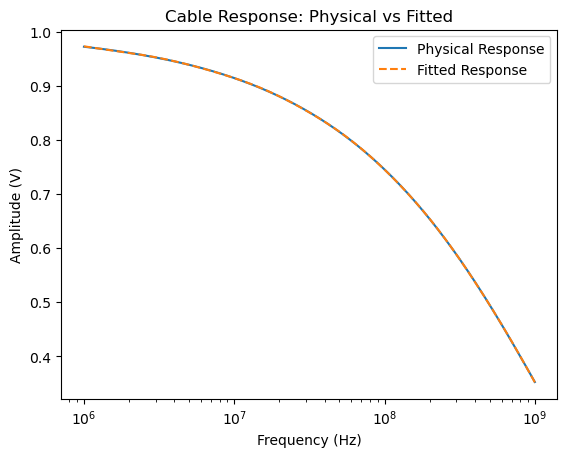

r1 = 1.8711590800533529, c1 = 4.643243802647323e-09
r2 = 2.384489707235371, c2 = 5.952791373313169e-10
r3 = 9.22568078373429, c3 = 3.2062435213651343e-11
r4 = 4.6482326282436865, c4 = 1.3042312497505008e-10
r5 = 20.159844337734402, c5 = 8.034779910933242e-12
c6 = 3.5277158357992895e-12


In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Constants
fmin = 1e6  # minimum frequency (Hz)
fmax = 1e9  # maximum frequency (Hz)
u = 1.26e-6  # magnetic permeability (H/m)
c = 300e6  # speed of light (m/s)
sigma = 58e6  # copper conductivity (S/m)
z0 = 50  # characteristic impedance (Ohms)
er = 2.3  # relative dielectric constant RG58U cable (solid Polyethylene)
tand = 0.00035  # loss tangent/dissipation factor (polyethylene)
w = 2 * np.pi * 4.5e-4  # cross-sectional cable width (m)
l = 30  # line length (m)

# Attenuation constants
a1 = (l / (2 * w * z0)) * np.sqrt(np.pi * u / sigma)  # skin effect
a2 = (l * np.pi * tand * np.sqrt(er)) / c  # dielectric effect

print(f"a1 = {a1}")
print(f"a2 = {a2}")

# Frequency range
frequencies = np.logspace(np.log10(fmin), np.log10(fmax), 650000)#step 650000

# Physical response
response = np.exp(-a1 * np.sqrt(frequencies) - a2 * frequencies)

# Save response to CSV
data = np.column_stack((frequencies, response))
df = pd.DataFrame(data, columns=['Frequency', 'Amplitude'])
df.to_csv('droop.csv', index=False)

# Define pole zero and pole equations
def pz(x, p, z):
    return (1 + ((2 * np.pi * x) / (2 * np.pi * z)) ** 2) / (1 + ((2 * np.pi * x) / (2 * np.pi * p)) ** 2)

def p(x, p):
    return 1 / (1 + ((2 * np.pi * x) / (2 * np.pi * p)) ** 2)

# Composite model function
def model(x, params):
    wp1, wz1, wp2, wz2, wp3, wz3, wp4, wz4, wp5, wz5, wp6 = params
    return np.sqrt(pz(x, wp1, wz1) * pz(x, wp2, wz2) * pz(x, wp3, wz3) * pz(x, wp4, wz4) * pz(x, wp5, wz5) * p(x, wp6))

# Residuals function
def residuals(params, x, y):
    return model(x, params) - y

# Initial parameter guesses
fscale = 1e9
initial_guess = [
    7e-3 * fscale, 8e-3 * fscale, 6e-2 * fscale, 7e-2 * fscale,
    2.5e-1 * fscale, 3.5e-1 * fscale, 0.25 * fscale, 0.1 * fscale,
    0.5 * fscale, 1.0 * fscale, 12.0 * fscale
]

# Load data from CSV
df = pd.read_csv('droop.csv')
x_data = df['Frequency'].values
y_data = df['Amplitude'].values

# Perform the fit
result = least_squares(residuals, initial_guess, args=(x_data, y_data))
optimized_params = result.x

"""
Calculate the Standard Error
Multiplying all elements of this matrix by the residual variance 
and taking the square root of the diagonal elements 
will give you an estimate of the standard deviation of the fit parameters. 
"""
J = result.jac  # Jacobian matrix at the solution
matrixProduct = J.T @ J # matrix product of the transpose of J and J itself
hessian = np.linalg.inv(matrixProduct) # a Gauss-Newton approximation of the Hessian of the cost function.
varRes = np.var(result.fun) #  the variance of the residuals
cov_matrix = hessian * varRes #Multiplying all elements of the Hessian by the residual variance
standard_errors = np.sqrt(np.diag(cov_matrix))

# Print optimized parameters and their standard errors
print("Optimized parameters and their standard errors:")
count = 1
for i, (param, std_err) in enumerate(zip(optimized_params, standard_errors), start=1):
    if i % 2 != 0:
        print(f"wp{count} = {param:.5g}, std_err = {std_err:.5g}",f" ({std_err/param:.3%})")
    else:
        print(f"wz{count} = {param:.5g}, std_err = {std_err:.5g}",f" ({std_err/param:.3%})")
        count += 1
    
  
# Plot the results
plt.plot(x_data, y_data, label='Physical Response')
plt.plot(x_data, model(x_data, optimized_params), label='Fitted Response', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.title('Cable Response: Physical vs Fitted')
plt.show()

# Calculate Rs and Cs for pole/zero schematic
wp1, wz1, wp2, wz2, wp3, wz3, wp4, wz4, wp5, wz5, wp6 = optimized_params

# Calculate Rs and Cs for SPICE
def calc_r_c(wp, wz):
    r = 50 * ((wz / wp) - 1)
    c = 1 / (2 * np.pi * 50 * wz)
    return r, c

r1, c1 = calc_r_c(wp1, wz1)
r2, c2 = calc_r_c(wp2, wz2)
r3, c3 = calc_r_c(wp3, wz3)
r4, c4 = calc_r_c(wp4, wz4)
r5, c5 = calc_r_c(wp5, wz5)
c6 = 1 / (2 * np.pi * 50 * wp6)

print(f"r1 = {r1}, c1 = {c1}")
print(f"r2 = {r2}, c2 = {c2}")
print(f"r3 = {r3}, c3 = {c3}")
print(f"r4 = {r4}, c4 = {c4}")
print(f"r5 = {r5}, c5 = {c5}")
print(f"c6 = {c6}")
